# W4_Ridge Regression (I)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import Ridge
from math import floor

In [2]:
# get polynomial dataframe
def get_polynomial_df(feature, degree):
    df = pd.DataFrame()
    df['power_1'] = feature.copy()
    
    if degree > 1:
        for power in range(2, degree+1):
            name = 'power_' + str(power)
            df[name] = feature.copy() ** power
    return df

In [3]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}
data = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)
data.sort_values(by=['sqft_living', 'price'], inplace=True)
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
19452,3980300371,20140926T000000,142000.0,0.0,0.00,290.0,20875,1.0,0,0,...,1,290,0,1963,0,98024,47.5308,-121.888,1620.0,22850.0
15381,2856101479,20140701T000000,276000.0,1.0,0.75,370.0,1801,1.0,0,0,...,5,370,0,1923,0,98117,47.6778,-122.389,1340.0,5000.0
860,1723049033,20140620T000000,245000.0,1.0,0.75,380.0,15000,1.0,0,0,...,5,380,0,1963,0,98168,47.4810,-122.323,1170.0,15000.0
18379,1222029077,20141029T000000,265000.0,0.0,0.75,384.0,213444,1.0,0,0,...,4,384,0,2003,0,98070,47.4177,-122.491,1920.0,224341.0
4868,6896300380,20141002T000000,228000.0,0.0,1.00,390.0,5900,1.0,0,0,...,4,390,0,1953,0,98118,47.5260,-122.261,2170.0,6000.0


In [4]:
# build a Ridge model with small penalty
poly15 = get_polynomial_df(data['sqft_living'], 15)
poly15['price'] = data['price'].copy()
l2_small_penalty = 1.5e-5
model15 = Ridge(alpha=l2_small_penalty, normalize=True).fit(poly15.drop('price', axis=1), poly15['price'])
# see the coefficient of power_1
print(model15.coef_[0])

124.873306483


In [5]:
# import 4 differeent ata sets
set_1 = pd.read_csv('wk3_kc_house_set_1_data.csv', dtype=dtype_dict)
set_2 = pd.read_csv('wk3_kc_house_set_2_data.csv', dtype=dtype_dict)
set_3 = pd.read_csv('wk3_kc_house_set_3_data.csv', dtype=dtype_dict)
set_4 = pd.read_csv('wk3_kc_house_set_4_data.csv', dtype=dtype_dict)

# compare different results using the same panalty
def comparing_4_datasets(penalty):
    
    i = 1
    
    for dataset in (set_1, set_2, set_3, set_4):
        poly = get_polynomial_df(dataset['sqft_living'], 15)
        poly['price'] = dataset['price']
        model = Ridge(alpha=penalty, normalize=True).fit(poly.drop('price', axis=1), poly['price'])
    
        plt.plot(poly['power_1'], model.predict(poly.drop('price', axis=1)), label='dataset_'+str(i))
        plt.xlabel('sqft living')
        plt.ylabel('estimated price')
        plt.legend()
    
        print("The coefficient of 'power_1' in the model using dataset {} is {}".format(i, round(model.coef_[0],3)))
    
        i += 1

The coefficient of 'power_1' in the model using dataset 1 is 544.669
The coefficient of 'power_1' in the model using dataset 2 is 859.363
The coefficient of 'power_1' in the model using dataset 3 is -755.396
The coefficient of 'power_1' in the model using dataset 4 is 1119.446


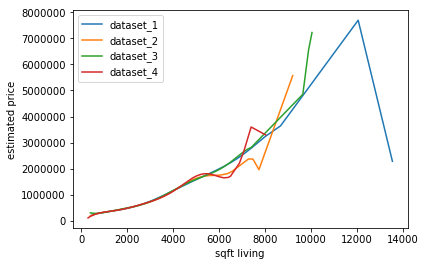

In [6]:
# use a small penalty
l2_small_penalty=1e-9
comparing_4_datasets(l2_small_penalty)

The coefficient of 'power_1' in the model using dataset 1 is 2.328
The coefficient of 'power_1' in the model using dataset 2 is 2.098
The coefficient of 'power_1' in the model using dataset 3 is 2.289
The coefficient of 'power_1' in the model using dataset 4 is 2.086


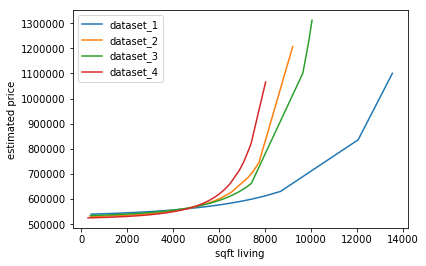

In [7]:
# use a big penalty
l2_large_penalty=1.23e2
comparing_4_datasets(l2_large_penalty)

In [8]:
train_valid_shuffled = pd.read_csv('wk3_kc_house_train_valid_shuffled.csv', dtype=dtype_dict)
test = pd.read_csv('wk3_kc_house_test_data.csv', dtype=dtype_dict)

In [9]:
data = get_polynomial_df(train_valid_shuffled['sqft_living'], 15)
data['price'] = train_valid_shuffled['price']

In [10]:
# implement k-cross-validation
def k_fold_cross_validation(k, l2_penalty, data):    
    n = len(data) 
    RSS = 0
    for i in range(k):
        start = floor((n/k) * i)
        end = floor((n/k) * (i+1))
        val_data = data[start:end+1]
        train_data = data[0:start].append(data[end+1:n])
        
        model = Ridge(alpha=l2_penalty, normalize=True).fit(train_data.drop('price', axis=1), train_data['price'])
        
        predictions = model.predict(val_data.drop('price', axis=1))
        RSS += sum((predictions - val_data['price']) ** 2)
    return RSS/k

min_rss = float('inf')
best_p = None
all_RSS = []

for penalty in np.logspace(3, 9, num=13):
    RSS = k_fold_cross_validation(10, penalty, data)
    all_RSS.append(RSS)
    if RSS < min_rss:
        min_rss = RSS
        best_p = penalty
df = pd.DataFrame(data=[np.logspace(3, 9, num=13), np.array(all_RSS)], index=['penalty', 'RSS'])
df
print('When panalty is {}, it has minimum RSS {}'.format(best_p, min_rss))

When panalty is 1000.0, it has minimum RSS 265017874561645.25


In [11]:
# use optimal penalty to train model and get test error
train = pd.read_csv('wk3_kc_house_train_data.csv', dtype=dtype_dict)
test = pd.read_csv('wk3_kc_house_test_data.csv', dtype=dtype_dict)
train_data = get_polynomial_df(train['sqft_living'], 15)
train_data['price'] = train['price']
test_data = get_polynomial_df(test['sqft_living'], 15)
test_data['price'] = test['price']
model = Ridge(alpha=best_p, normalize=True).fit(data.drop('price', axis=1), data['price'])
predictions = model.predict(test_data.drop('price', axis=1))
test_RSS = sum((predictions-test_data['price']) ** 2)
print(test_RSS)

2.83856861224e+14
